In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier, DMatrix, train

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/faysond/genres_original"
genres = os.listdir(DATASET_PATH)

def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=30)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
    return np.hstack([mfccs, chroma, mel, contrast, tonnetz])

In [ ]:
data = []
labels = []

for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    if not os.path.isdir(genre_path):
        continue

    file_count = 0
    for file in sorted(os.listdir(genre_path))[:100]:
        file_path = os.path.join(genre_path, file)
        try:
            features = extract_features(file_path)
            data.append(features)
            labels.append(genre)
            file_count += 1
        except Exception as e:
            print(f"Skipping {file}: {e}")

    print(f"Loaded {file_count} files from genre: {genre}")

✅ Loaded 100 files from genre: blues
✅ Loaded 100 files from genre: classical
✅ Loaded 100 files from genre: country
✅ Loaded 100 files from genre: disco
✅ Loaded 100 files from genre: hiphop
✅ Loaded 99 files from genre: jazz
✅ Loaded 100 files from genre: pop
✅ Loaded 100 files from genre: metal
✅ Loaded 100 files from genre: reggae
✅ Loaded 100 files from genre: rock


In [ ]:
df = pd.DataFrame(data)
df["genre"] = labels

label_encoder = LabelEncoder()
df["genre"] = label_encoder.fit_transform(df["genre"])

In [ ]:
X = df.drop(columns=["genre"])
y = df["genre"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

dtrain = DMatrix(X_train, label=y_train)
dval = DMatrix(X_val, label=y_val)
dtest = DMatrix(X_test, label=y_test)

In [ ]:
params = {
    "objective": "multi:softmax",
    "num_class": len(np.unique(y_train)),
    "eval_metric": ["mlogloss", "merror"],
    "verbosity": 2
}

print("Starting Training...")
watchlist = [(dtrain, "train"), (dval, "eval")]
xgb_model = train(params, dtrain, num_boost_round=150, evals=watchlist, early_stopping_rounds=10, verbose_eval=1)
print("Training Completed!")

Starting Training...
[0]	train-mlogloss:1.49540	train-merror:0.09011	eval-mlogloss:1.88220	eval-merror:0.44000
[1]	train-mlogloss:1.11559	train-merror:0.03504	eval-mlogloss:1.67424	eval-merror:0.42000
[2]	train-mlogloss:0.87466	train-merror:0.02128	eval-mlogloss:1.51570	eval-merror:0.38000
[3]	train-mlogloss:0.69414	train-merror:0.01627	eval-mlogloss:1.40318	eval-merror:0.34000
[4]	train-mlogloss:0.55719	train-merror:0.00375	eval-mlogloss:1.32645	eval-merror:0.35000
[5]	train-mlogloss:0.45600	train-merror:0.00250	eval-mlogloss:1.26334	eval-merror:0.34000
[6]	train-mlogloss:0.37796	train-merror:0.00125	eval-mlogloss:1.20836	eval-merror:0.33000
[7]	train-mlogloss:0.31659	train-merror:0.00125	eval-mlogloss:1.16670	eval-merror:0.30000
[8]	train-mlogloss:0.26648	train-merror:0.00125	eval-mlogloss:1.11855	eval-merror:0.29000
[9]	train-mlogloss:0.22454	train-merror:0.00125	eval-mlogloss:1.08353	eval-merror:0.28000
[10]	train-mlogloss:0.19065	train-merror:0.00125	eval-mlogloss:1.05724	eval-mer

In [ ]:
y_pred = xgb_model.predict(dtest)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Model Accuracy: {accuracy * 100:.2f}%")


Final Model Accuracy: 71.00%


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       blues       0.75      0.60      0.67        10
   classical       0.91      1.00      0.95        10
     country       0.64      0.70      0.67        10
       disco       0.67      0.60      0.63        10
      hiphop       0.47      0.70      0.56        10
        jazz       0.78      0.70      0.74        10
       metal       0.89      0.80      0.84        10
         pop       1.00      0.70      0.82        10
      reggae       0.78      0.70      0.74        10
        rock       0.50      0.60      0.55        10

    accuracy                           0.71       100
   macro avg       0.74      0.71      0.72       100
weighted avg       0.74      0.71      0.72       100



In [ ]:
xgb_model.save_model("music_genre_model.json")
np.save("label_encoder.npy", label_encoder.classes_)
np.save("scaler.npy", scaler)

In [ ]:
params = {
    "objective": "multi:softmax",
    "num_class": len(np.unique(y_train)),
    "eval_metric": ["mlogloss", "merror"],
    "verbosity": 2,
    "reg_alpha": 0.1,
    "reg_lambda": 1.0
}

print("Starting Training...")
watchlist = [(dtrain, "train"), (dval, "eval")]

evals_result = {}
xgb_model = train(params, dtrain, num_boost_round=150, evals=watchlist,
                  early_stopping_rounds=10, verbose_eval=1,
                  evals_result=evals_result)
print("Training Completed!")

results = evals_result

Starting Training...
[0]	train-mlogloss:1.50296	train-merror:0.09637	eval-mlogloss:1.87435	eval-merror:0.44000
[1]	train-mlogloss:1.12303	train-merror:0.04130	eval-mlogloss:1.67067	eval-merror:0.41000
[2]	train-mlogloss:0.87629	train-merror:0.02003	eval-mlogloss:1.49953	eval-merror:0.38000
[3]	train-mlogloss:0.69408	train-merror:0.01252	eval-mlogloss:1.40077	eval-merror:0.36000
[4]	train-mlogloss:0.56491	train-merror:0.00626	eval-mlogloss:1.33196	eval-merror:0.35000
[5]	train-mlogloss:0.46689	train-merror:0.00375	eval-mlogloss:1.27750	eval-merror:0.32000
[6]	train-mlogloss:0.38592	train-merror:0.00375	eval-mlogloss:1.20347	eval-merror:0.32000
[7]	train-mlogloss:0.32291	train-merror:0.00375	eval-mlogloss:1.16955	eval-merror:0.32000
[8]	train-mlogloss:0.27375	train-merror:0.00125	eval-mlogloss:1.13408	eval-merror:0.32000
[9]	train-mlogloss:0.22993	train-merror:0.00125	eval-mlogloss:1.10305	eval-merror:0.30000
[10]	train-mlogloss:0.19502	train-merror:0.00125	eval-mlogloss:1.09060	eval-mer

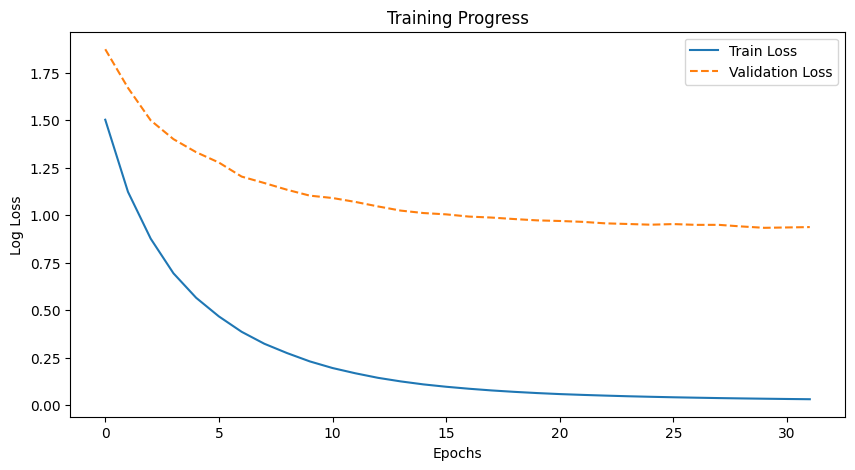

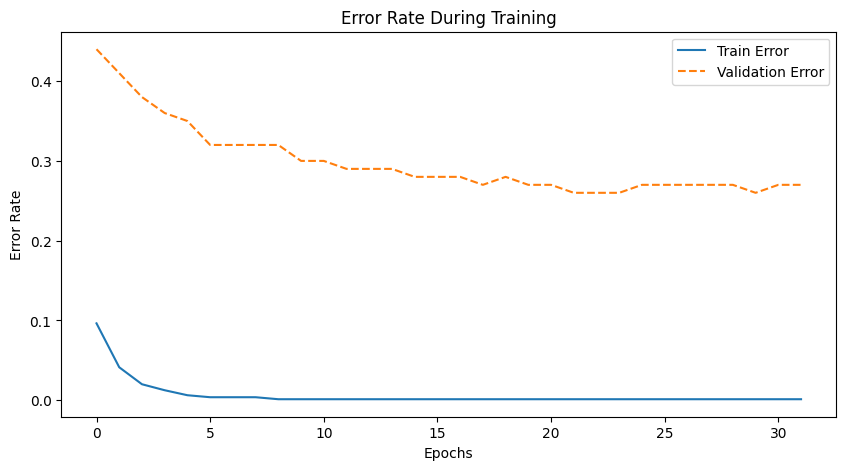

In [ ]:


plt.figure(figsize=(10, 5))
plt.plot(results['train']['mlogloss'], label='Train Loss')
plt.plot(results['eval']['mlogloss'], label='Validation Loss', linestyle="dashed")
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results['train']['merror'], label='Train Error')
plt.plot(results['eval']['merror'], label='Validation Error', linestyle="dashed")
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.title('Error Rate During Training')
plt.show()

In [ ]:
# Make predictions
y_pred = xgb_model.predict(dtest)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Model Accuracy: {accuracy * 100:.2f}%")


Final Model Accuracy: 74.00%


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0.1, 1.0, 10.0],
    'reg_lambda': [0.1, 1.0, 10.0]
}


grid_search = GridSearchCV(estimator=XGBClassifier(**params),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

xgb_model = XGBClassifier(**params, **best_params)
xgb_model.fit(X_train, y_train)